Uodate <u>PARAMETERS.json</u> with **current** date and time

In [1]:
import json
from datetime import datetime
import os

file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2024-12-04 21:45:14.


<!-- Initialize **API** **managers** -->

In [2]:
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re


print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'PARAMETERS.json', '__pycache__', 'data_analysis.ipynb']


(Optional) Update mongoDB for visualizing coordinates

In [3]:
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector


connector = DBConnector()
if connector.check_connection():
    print("Proceed with operations.")
else:
    print("Fix connection issues before proceeding.")

Connection to MongoDB is successful!
Proceed with operations.


1. Convert **JSON** to **CSV** so that **pandas** be able to use it
2. Create **csv** for every vehicle



In [4]:
import pandas as pd
from pathlib import Path
import csv


# Function to save a DataFrame to a CSV file
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Save the DataFrame to CSV
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop

while _cnt <= 100:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_df = pd.DataFrame(snapshot_data_list)
        
        # Save the DataFrame to CSV only if it's not empty
        save_to_csv(snapshot_df, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1

print("Process complete!")


**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_1_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_2_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_3_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_4_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_5_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_6_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_7_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehi

Visualize data **dispersion**

1) Plot **unique** vehicles

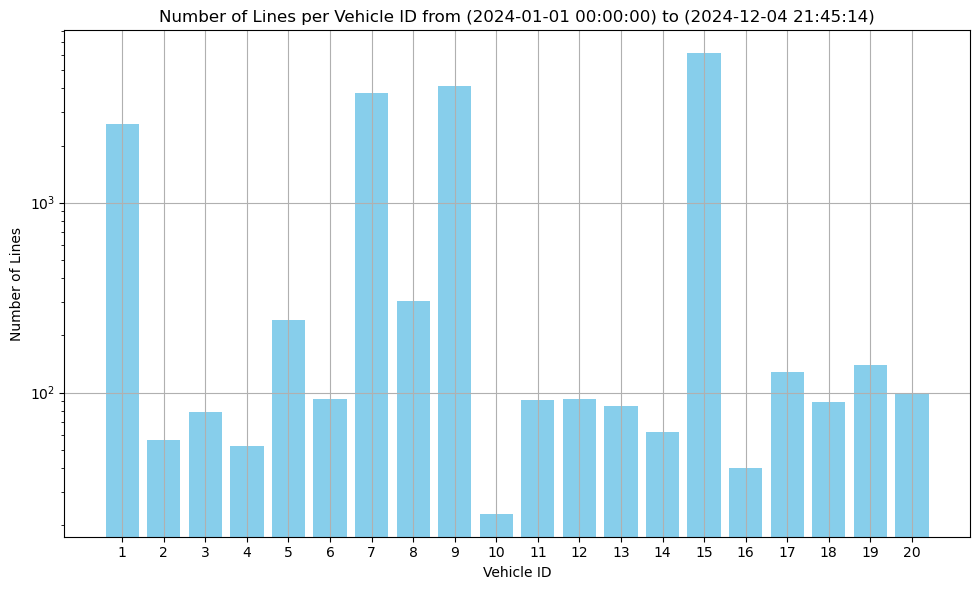

In [5]:
import matplotlib.pyplot as plt

# Path to the folder containing the CSV files
folder_path = "../../DataSets/API_Responses/Vehicle_Data/"  # Modify with your folder path

# Initialize an empty dictionary to store vehicleId (as an integer for sorting) and its corresponding row count
vehicle_lines = {}

# Loop through the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file and starts with "Vehicle_"
    if file_name.endswith(".csv") and file_name.startswith("Vehicle_"):
        # Extract the vehicleId from the file name (assuming the naming convention is 'Vehicle_<id>.csv')
        vehicle_id_str = file_name.split('_')[1].split('.')[0]  # Extract the part after "Vehicle_" and before ".csv"
        
        # Ensure vehicle_id is numeric; if not, skip the file
        try:
            vehicle_id = int(vehicle_id_str)  # Convert to integer for proper sorting
        except ValueError:
            print(f"Skipping file with non-numeric Vehicle ID: {file_name}")
            continue

        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file to count the number of rows (excluding the header)
        try:
            df = pd.read_csv(file_path)
            vehicle_lines[vehicle_id] = len(df)  # Store the line count for each vehicleId
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

# Sort the dictionary by vehicleId (numerically in ascending order)
sorted_vehicle_lines = dict(sorted(vehicle_lines.items()))

# Convert the sorted dictionary to two lists for plotting
vehicle_ids = list(sorted_vehicle_lines.keys())
line_counts = list(sorted_vehicle_lines.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(vehicle_ids, line_counts, color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Lines')
plt.title(f'Number of Lines per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(vehicle_ids)  # Rotate vehicle IDs if needed
plt.tight_layout()
plt.grid()

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")

# Show the plot
plt.show()


2. **vehicleId=15** seems to have the most lines. Plot it's **velocities**

Define constants

In [6]:
VEHICLE_15_PATH = "../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response.csv"

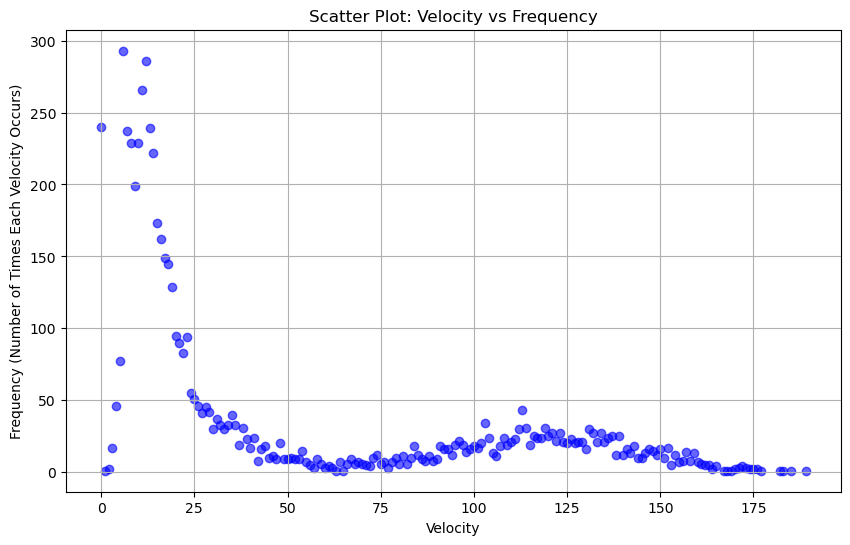

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(VEHICLE_15_PATH)

# Check if the "velocity" column exists
if "velocity" in df.columns:
    # Convert 'velocity' column to float, coercing errors to NaN (if any invalid entries exist)
    df['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')
    
    # Drop any rows where 'velocity' is NaN after conversion 
    df = df.dropna(subset=['velocity'])
    
    # Count the occurrences of each unique velocity
    velocity_counts = df['velocity'].value_counts().sort_index()

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(velocity_counts.index, velocity_counts.values, color='b', alpha=0.6)

    # Customize the plot
    plt.title("Scatter Plot: Velocity vs Frequency")
    plt.xlabel("Velocity")
    plt.ylabel("Frequency (Number of Times Each Velocity Occurs)")
    plt.grid(True)

    # Show the plot
    plt.show()

else:
    print("The 'velocity' column is not present in the dataset.")


3. Get the data from the first time sent (the oldest timestamp) to the last (the most recent), you should sort the data in ascending order by the **"dataStored" column**

In [8]:
if 'dateStored' in df.columns:
    # Sort the DataFrame by 'dateStored' in ascending order (oldest to newest)
    df_sorted = df.sort_values(by='dateStored', ascending=True)
    
    #* Reset the index after sorting for future usage
    df_sorted.reset_index(drop=True, inplace=True)
    
    print("Data sorted by 'dateStored'")
else:
    print("The 'dateStored' column is not found in the dataset.")



Data sorted by 'dateStored'


4. Group by **less than** 1.30 minutes with <u>0 data sent</u>, based on the **"dateStored" column**.

In [ ]:
def segment_by_time_threshold_less(data, date_column, threshold_seconds=90):
    """
    Segments data into groups where the time difference between consecutive rows
    is less than the specified threshold.
    
    Args:
        data (pd.DataFrame): The input dataframe.
        date_column (str): The name of the column containing UNIX timestamps.
        threshold_seconds (int): The time gap (in seconds) used for segmentation.

    Returns:
        list[pd.DataFrame]: A list of segmented DataFrames.
    """
    # Convert UNIX timestamps to datetime if not already done
    data['datetime']    = pd.to_datetime(data[date_column], unit='s')
    
    # Calculate time difference between consecutive rows
    data['time_diff']   = data['datetime'].diff().dt.total_seconds()
    
    # Create a group identifier for segments where the time gap is less than the threshold
    data['segment']     = (data['time_diff'] >= threshold_seconds).cumsum()
    
    # Split the data into groups
    segmented_data      = [group for _, group in data.groupby('segment') if (group['time_diff'] < threshold_seconds).any()]
    
    return segmented_data


Usage Example

In [25]:
import pandas as pd
import numpy as np

def segment_by_time_threshold_less(data, date_column, threshold_seconds=90):
    """
    Segments data into groups where the time difference between consecutive rows
    is less than the specified threshold, while handling invalid timestamps by filling
    with the previous valid timestamp.
    """
    # Define valid UNIX timestamp range
    min_unix = 0  # 1970-01-01
    max_unix = 32503680000  # Year 3000 (seconds since 1970-01-01)

    # Convert to numeric and identify invalid rows
    data[date_column] = pd.to_numeric(data[date_column], errors='coerce')
    
    # Remove timestamps that are out of bounds
    data[date_column] = data[date_column].where((data[date_column] >= min_unix) & (data[date_column] <= max_unix))
    
    # Fill invalid timestamps by taking the previous valid timestamp
    data['filled_date'] = data[date_column].fillna(method='ffill')  # Forward fill

    # Handle the invalid data (if any) by using the previous timestamp for filling
    # Specifically, look at the previous and next timestamps for better filling strategy
    for idx in range(1, len(data)):
        if pd.isna(data.loc[idx, 'filled_date']):
            prev_time = data.loc[idx - 1, 'filled_date']
            next_time = data.loc[idx + 1, 'filled_date'] if idx + 1 < len(data) else None
            if prev_time and next_time:
                data.loc[idx, 'filled_date'] = prev_time  # Use previous valid timestamp
            # Handle edge case for the very first row if needed
            if prev_time and next_time is None:
                data.loc[idx, 'filled_date'] = prev_time

    # Now, convert the filled UNIX timestamps to datetime, with invalid ones handled
    data['datetime'] = pd.to_datetime(data['filled_date'], unit='s', errors='coerce')

    # Handle any invalid datetime after conversion
    data['datetime'] = data['datetime'].fillna(method='ffill')  # Forward fill after conversion

    # Calculate time difference between consecutive rows
    data['time_diff'] = data['datetime'].diff().dt.total_seconds()

    # Handle the first row time_diff to avoid NaN value
    if pd.isna(data.loc[0, 'time_diff']):
        data.loc[0, 'time_diff'] = 0

    # Create a group identifier for segments where the time gap is less than the threshold
    data['segment'] = (data['time_diff'] >= threshold_seconds).cumsum()

    # Split the data into groups
    segmented_data = [
        group for _, group in data.groupby('segment')
        if (group['time_diff'] < threshold_seconds).any()
    ]

    return segmented_data

def process_csv(input_csv, date_column, threshold_seconds=90):
    # Read the CSV data
    data = pd.read_csv(input_csv)
    
    # Call the segment function
    segmented_data = segment_by_time_threshold_less(data, date_column, threshold_seconds)
    
    # Optionally, save each segment to a separate CSV file
    for i, segment in enumerate(segmented_data):
        segment_filename = f"segment_{i + 1}.csv"
        segment.to_csv(segment_filename, index=False)
        print(f"Saved {segment_filename}")

# Example usage:
input_csv = VEHICLE_15_PATH  # Update with your CSV file path
process_csv(input_csv, 'dateStored', threshold_seconds=90)


Saved segment_1.csv


**Reusable Method to Convert UNIX Timestamps**

In [10]:
def unix_to_datetime_pandas(unix_timestamp_column):
    """Convert a column of UNIX timestamps to human-readable datetime."""
    return pd.to_datetime(unix_timestamp_column, unit='s')